In [1]:
import jax.numpy as jnp
import jax
import jax.scipy as jsp
import matplotlib.pyplot as plt
import os

Lets load some images.

In [49]:
def load_data(path, grid_size=128):
    # get all files in path
    files = os.listdir(path)
    # sort files
    files.sort()
    print(files)
    # read binary files
    data = []
    for file in files:
        with open(os.path.join(path, file), 'rb') as f:
            grid = jnp.frombuffer(f.read(), dtype=jnp.float32)
            grid = grid.reshape(grid_size, grid_size, grid_size)
            data.append(grid)
        
    return jnp.array(data)

grids = load_data('data/grid/01')

print(grids.shape)

['example.00005.0', 'example.00010.0', 'example.00015.0', 'example.00020.0', 'example.00025.0', 'example.00030.0', 'example.00035.0', 'example.00040.0', 'example.00045.0', 'example.00050.0', 'example.00055.0', 'example.00060.0', 'example.00065.0', 'example.00070.0', 'example.00075.0', 'example.00080.0', 'example.00085.0', 'example.00090.0']
(18, 128, 128, 128)


In [55]:
def preprocess(data, grid_size=64):
    # resize data
    data = jnp.array([jax.image.resize(data[i], (grid_size, grid_size, grid_size), method='tricubic') for i in range(data.shape[0])])

    return data

grids_resized = preprocess(grids, 32)

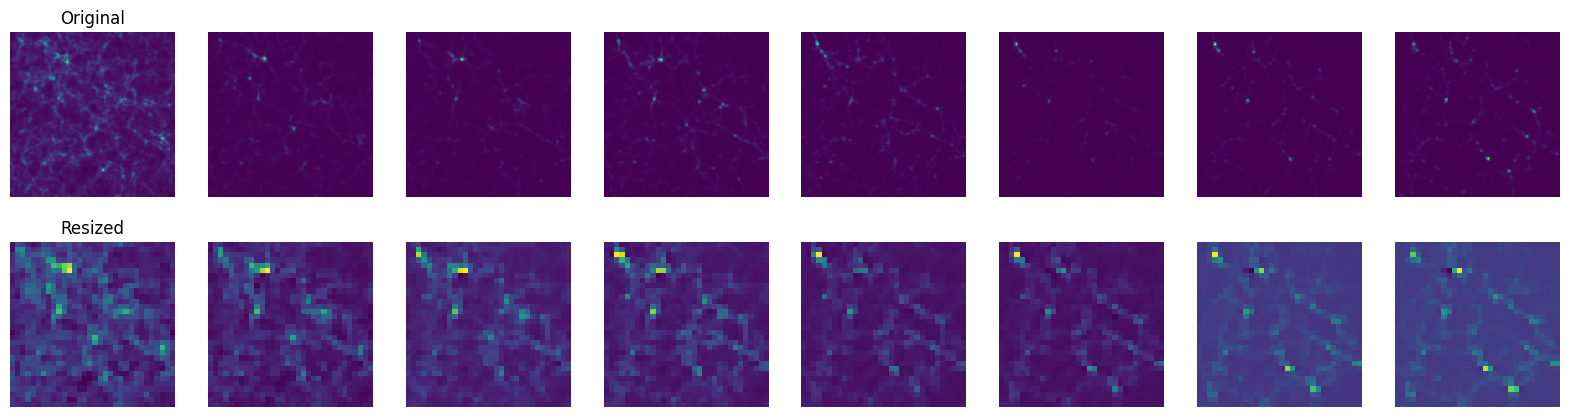

In [56]:
# plot a few slices
fig, ax = plt.subplots(2, 8, figsize=(20, 5))
# plot with normalized colormap
for i in range(8):
    ax[0, i].imshow(grids[i, :, :, grids.shape[-1] //2], cmap='viridis')
    ax[1, i].imshow(grids_resized[i, :, :, grids_resized.shape[-1]//2], cmap='viridis')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    # set titles
    if i == 0:
        ax[0, i].set_title('Original')
        ax[1, i].set_title('Resized')

In [59]:
from flax import linen as nn
import optax

In [80]:
class Encoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.Conv(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.Conv(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.Conv(features=8*self.n_channels, kernel_size=(3, 3), strides=(2, 2))

    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)
        return x

In [81]:
class Decoder(nn.Module):
    n_channels: int

    def setup(self):
        self.conv1 = nn.ConvTranspose(features=8*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv2 = nn.ConvTranspose(features=4*self.n_channels, kernel_size=(3, 3), strides=(2, 2))
        self.conv3 = nn.ConvTranspose(features=self.n_channels, kernel_size=(3, 3), strides=(2, 2))
    
    def __call__(self, x):
        x = self.conv1(x)
        x = jax.nn.relu(x)
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = self.conv3(x)
        x = jax.nn.relu(x)

        return x

In [82]:
class Autoencoder(nn.Module):
    n_channels: int

    def setup(self):
        self.encoder = Encoder(n_channels=self.n_channels)
        self.decoder = Decoder(n_channels=self.n_channels)
    
    def __call__(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [83]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, images : jnp.ndarray):
  # print(images.shape)
  prediction = network.apply(network_params, images)
  # print(prediction.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.sum(jnp.square(prediction - images), axis=(-1)))
  return loss

@partial(jax.jit, static_argnums=(1,2))
def train_step(
  batch : jnp.ndarray,
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, batch)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state


In [84]:
init_rng = jax.random.key(0)

learning_rate = 0.003

autoencoder = Autoencoder(n_channels=3)

network_params = autoencoder.init(init_rng, batches[0][0])
print(batches[0].shape)
# autoencoder_params = autoencoder_state
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 60

for epoch in range(num_epochs):

    def body_func(i, state):
        loss_sum, network_params, optimizer_state = state
        loss, network_params, optimizer_state = train_step(batches[i], autoencoder, optimizer, optimizer_state, network_params)
        return loss_sum + loss, network_params, optimizer_state
    
    state = (0., network_params, optimizer_state)
    state = jax.lax.fori_loop(0, len(batches), body_func, state)

    loss, network_params, optimizer_state = state

    print(f"Epoch {epoch}, Loss: {loss}")


(16, 32, 32, 3)
Epoch 0, Loss: 7.732458591461182
Epoch 1, Loss: 2.2779312133789062
Epoch 2, Loss: 1.2531018257141113
Epoch 3, Loss: 0.9705828428268433
Epoch 4, Loss: 0.8239234685897827
Epoch 5, Loss: 0.7117134928703308
Epoch 6, Loss: 0.6290988326072693
Epoch 7, Loss: 0.5854718685150146
Epoch 8, Loss: 0.5569334030151367
Epoch 9, Loss: 0.5363137722015381
Epoch 10, Loss: 0.5202783346176147
Epoch 11, Loss: 0.5078360438346863
Epoch 12, Loss: 0.49490469694137573
Epoch 13, Loss: 0.48521655797958374
Epoch 14, Loss: 0.47878697514533997
Epoch 15, Loss: 0.47172048687934875
Epoch 16, Loss: 0.4648224115371704
Epoch 17, Loss: 0.4590007960796356
Epoch 18, Loss: 0.45131900906562805
Epoch 19, Loss: 0.44272381067276
Epoch 20, Loss: 0.43506336212158203
Epoch 21, Loss: 0.43038254976272583
Epoch 22, Loss: 0.423811674118042
Epoch 23, Loss: 0.4172925353050232
Epoch 24, Loss: 0.40999671816825867
Epoch 25, Loss: 0.40288376808166504
Epoch 26, Loss: 0.39572447538375854
Epoch 27, Loss: 0.3882328271865845
Epoch 28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.057508983..1.0169439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.028339721..1.036851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11501227..1.1578596].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.008421053..1.0748769].


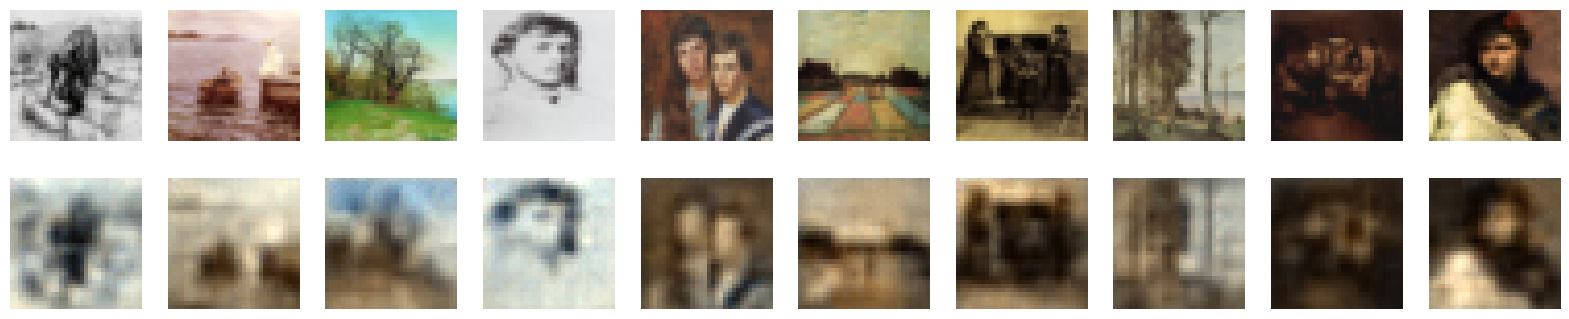

In [91]:
# plot a few reconstructions and the original images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axs[0, i].imshow(batches[1][i])
    axs[0, i].axis("off")
    axs[1, i].imshow(autoencoder.apply(network_params, batches[1][i][None])[0])
    axs[1, i].axis("off")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3455393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5550222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3730304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4017879].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.7117834].


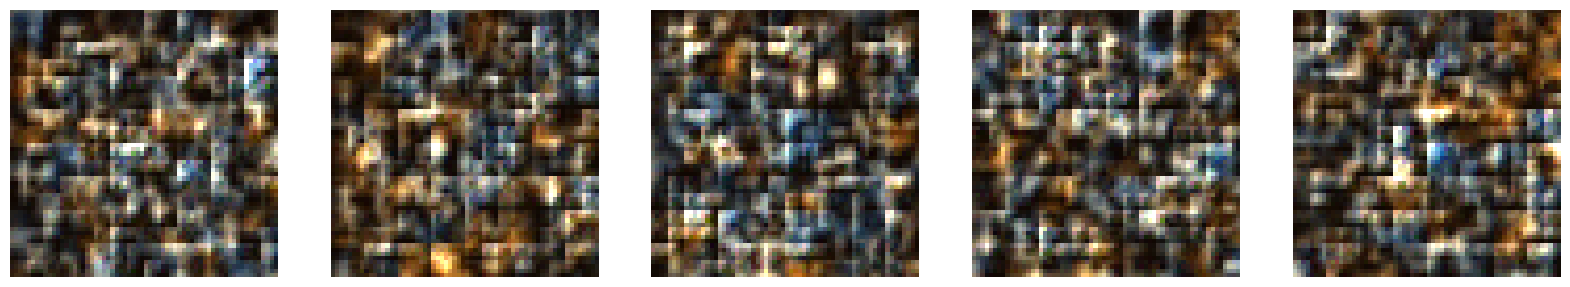

In [92]:
# generate new images from the latent space

encoder = Decoder(n_channels=3)
params = {'params':network_params['params']['decoder']}

keys = jax.random.split(init_rng, 5)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    latent = jax.random.normal(keys[i], (1, 8, 8, 3*8))
    image = encoder.apply(params, latent)
    axs[i].imshow(image[0])
    axs[i].axis("off")
